# Forest extent gain, loss, and stable
Input: 
- Forest4model_v1_Forest_extent_gain

Aim:
- Visualising forest extent gain, loss, and stable in sample countries
- Calculating percentage share of forest extent gain, loss, and stable over country's total forest cover

Output:
- A dataframe containing the percentage share of forest extent gain, loss, and stable in 32 EU countries

In [48]:
# Vector data
import geopandas as gpd

# Tabular data 
import pandas as pd
import numpy as np

# Raster array
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# System
from pathlib import Path

# Import functions from geo_tools module
from geo_tools import utils, forest_barplot, plot_iso_forest

# Reloads module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Output directory

In [2]:
# Specify the desired output folder path for processed dataset
output_data_dir = Path.cwd() / ".." / "output_data"

# Check if the output folder exists, and create if not
Path.mkdir(output_data_dir, exist_ok=True, parents=True)

In [3]:
# Specify the desired output folder path for figures
output_figure_dir = Path.cwd() / ".." / "output_figures"

# Check if the output folder exists, and create if not
Path.mkdir(output_figure_dir, exist_ok=True, parents=True)

# A list of ISO3 codes of EU countries

In [4]:
eu_iso3 = pd.read_csv(output_data_dir/"Country_Codes_and_Names_ISO3.csv")

eu_iso = eu_iso3["ISO3"]

# Plotting data distribution
TODO:
- Import forest extent stable, loss, and gain at once
- Plot them using categorical colorbar

In [51]:
%%time

file  = ["Forest_extent_loss", "Forest_extent_gain", "Forest_extent_stable"]
all_data = {}

for iso in ["DEU"]:
    iso_data = {}
    iso_border = {}

    for f in file:

        # Clipping to country border
        iso_data[f], border = utils.clip_array(iso_code=iso, xarray_id=f)

        # Close xarray
        iso_data[f].close()

    iso_combined = xr.merge(
        [
            iso_data["Forest_extent_loss"], 
            iso_data["Forest_extent_gain"], 
            iso_data["Forest_extent_stable"]
        ]
    )

    # Re-code the values according to the specified rules
    iso_combined = xr.where(iso_combined == iso_data["Forest_extent_loss"], -1, iso_combined)
    iso_combined = xr.where(iso_combined == iso_data["Forest_extent_gain"], 1, iso_combined)
    iso_combined = xr.where(iso_combined == iso_data["Forest_extent_stable"], 0, iso_combined)

    # Add attributes to the combined_data
    iso_combined.attrs.update({
        'country' : iso,
        'description': 'Combined forest loss, gain, and stable data with re-coded values',
        're-coding': 'Values == +1 for forest gain, -1 for forest loss, and 0 for forest stable'
    })

    all_data[iso] = iso_combined

    # Store country boundaries
    iso_border[iso] = border

CPU times: user 5.27 s, sys: 1.13 s, total: 6.4 s
Wall time: 6.4 s


In [46]:
# all_data["DEU"]

In [53]:
iso_border["DEU"]

,FIPS,ISO2,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,_count_2,_sum_2,geometry
ISO3,,,,,,,,,,,,,
DEU,GM,DE,276,Germany,34895,82652369,150,155,9.851,51.11,651325.0,70693.0,"MULTIPOLYGON (((8.71026 47.69681, 8.67860 47.6..."


CPU times: user 3.36 s, sys: 947 ms, total: 4.31 s
Wall time: 4.31 s


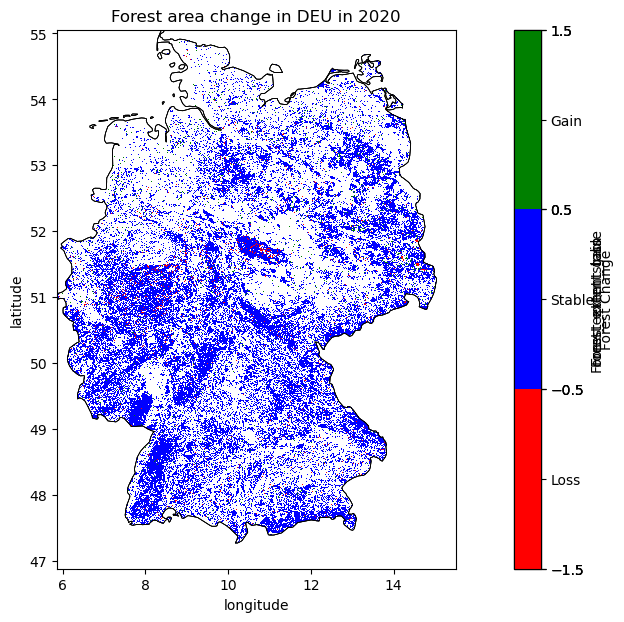

In [58]:
%%time

# Create a custom discrete colormap
cmap = mcolors.ListedColormap(['red', 'blue', 'green'])
bounds = [-1.5, -0.5, 0.5, 1.5]  # Define the boundaries for the colormap
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for iso in all_data.keys():

    # Figure template
    figure, ax = plt.subplots(figsize=(15,7))

    for var in all_data[iso].data_vars:
        data = all_data[iso][var]

        # Plot the data without a label
        img = data.plot.imshow(cmap=cmap, label=none, ax=ax, norm=norm)

        # # Remove cbar
        cbar = plt.colorbar(img)
        cbar.remove()
        cbar.set_label('')

        # Plot administration border
        iso_border["DEU"].boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

    # Add a color bar
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=[-1, 0, 1])
    cbar.set_ticklabels(['Loss', 'Stable', 'Gain'])
    cbar.set_label('Forest Change')

    ax.set_title(f'Forest area change in {iso} in 2020')

# Calculating area

### Forest extent gain

In [19]:
%%time
# Template to store total area in Mha
gain_mha = []

# Template to store total area in percentage share
gain_perc = []

# Import forest cover data
forest_cover = pd.read_csv(output_data_dir/"iso_forest_cover_stats.csv")

for iso in eu_iso:

    # Calculate area of undefined forest
    iso_gain = plot_iso_forest.agg_total_area(
        iso_code=iso, 
        xarray_id="Forest_extent_gain", 
        forest_layer_year=2020
    )
    gain_mha.append(iso_gain)

    # Get forest cover area within the country
    iso_forest_cover = forest_cover.loc[forest_cover.Region == iso]
    value_to_copy = iso_forest_cover.iloc[0, 5]

    # Copy forest cover to iso_fraction_class
    iso_gain[f"{iso}_forest_cover_Mha"] = value_to_copy

    # Calculate percentage share of fraction classes over total forest cover
    iso_gain["Percentage share"] = iso_gain["Value"] / iso_gain[f"{iso}_forest_cover_Mha"]

    # Creating final dataset
    iso_gain_perc = iso_gain.drop(["Unit", "Value", f"{iso}_forest_cover_Mha"], axis=1)

    iso_gain_perc.insert(
        loc=3,
        column="Unit",
        value="Percentage share"
    )

    iso_gain_perc.rename(
        columns={"Percentage share" : "Value"},
        inplace=True
    )
    gain_perc.append(iso_gain_perc)

gain_perc_df = pd.concat(gain_perc)

CPU times: user 43.1 s, sys: 11.1 s, total: 54.3 s
Wall time: 5min 59s


In [20]:
gain_perc_df

,Region,Variable,Year,Unit,Value
0,BGR,Forest extent gain,2020,Percentage share,0.024648
0,CYP,Forest extent gain,2020,Percentage share,0.033876
0,DNK,Forest extent gain,2020,Percentage share,0.180997
0,IRL,Forest extent gain,2020,Percentage share,0.543346
0,EST,Forest extent gain,2020,Percentage share,0.065402
0,AUT,Forest extent gain,2020,Percentage share,0.007351
0,CZE,Forest extent gain,2020,Percentage share,0.024597
0,FIN,Forest extent gain,2020,Percentage share,0.061759
0,FRA,Forest extent gain,2020,Percentage share,0.041585
0,DEU,Forest extent gain,2020,Percentage share,0.028334


### Forest extent loss

In [23]:
%%time
# Template to store total area in Mha
loss_mha = []

# Template to store total area in percentage share
loss_perc = []

# Import forest cover data
forest_cover = pd.read_csv(output_data_dir/"iso_forest_cover_stats.csv")

for iso in eu_iso:

    # Calculate area of undefined forest
    iso_loss = plot_iso_forest.agg_total_area(
        iso_code=iso, 
        xarray_id="Forest_extent_loss", 
        forest_layer_year=2020
    )
    loss_mha.append(iso_loss)

    # Get forest cover area within the country
    iso_forest_cover = forest_cover.loc[forest_cover.Region == iso]
    value_to_copy = iso_forest_cover.iloc[0, 5]

    # Copy forest cover to iso_fraction_class
    iso_loss[f"{iso}_forest_cover_Mha"] = value_to_copy

    # Calculate percentage share of fraction classes over total forest cover
    iso_loss["Percentage share"] = iso_loss["Value"] / iso_loss[f"{iso}_forest_cover_Mha"]

    # Creating final dataset
    iso_loss_perc = iso_loss.drop(["Unit", "Value", f"{iso}_forest_cover_Mha"], axis=1)

    iso_loss_perc.insert(
        loc=3,
        column="Unit",
        value="Percentage share"
    )

    iso_loss_perc.rename(
        columns={"Percentage share" : "Value"},
        inplace=True
    )
    loss_perc.append(iso_loss_perc)

loss_perc_df = pd.concat(loss_perc)

CPU times: user 42.8 s, sys: 11.1 s, total: 53.9 s
Wall time: 5min 41s


In [24]:
loss_perc_df

,Region,Variable,Year,Unit,Value
0,BGR,Forest extent loss,2020,Percentage share,0.010035
0,CYP,Forest extent loss,2020,Percentage share,0.022367
0,DNK,Forest extent loss,2020,Percentage share,0.104544
0,IRL,Forest extent loss,2020,Percentage share,0.171796
0,EST,Forest extent loss,2020,Percentage share,0.090649
0,AUT,Forest extent loss,2020,Percentage share,0.032291
0,CZE,Forest extent loss,2020,Percentage share,0.045327
0,FIN,Forest extent loss,2020,Percentage share,0.078726
0,FRA,Forest extent loss,2020,Percentage share,0.042462
0,DEU,Forest extent loss,2020,Percentage share,0.025372


### Forest extent stable

In [30]:
# Merge the dataframes on the 'Region' column
merged_df = pd.merge(gain_perc_df, loss_perc_df, on='Region', suffixes=('_gain', '_loss'))

In [31]:
# Calculate the stable forest extent
merged_df["Value_stable"] = 1 - (merged_df['Value_gain'] + merged_df['Value_loss'])

In [32]:
merged_df.head()

,Region,Variable_gain,Year_gain,Unit_gain,Value_gain,Variable_loss,Year_loss,Unit_loss,Value_loss,Value_stable
0,BGR,Forest extent gain,2020,Percentage share,0.024648,Forest extent loss,2020,Percentage share,0.010035,0.965318
1,CYP,Forest extent gain,2020,Percentage share,0.033876,Forest extent loss,2020,Percentage share,0.022367,0.943757
2,DNK,Forest extent gain,2020,Percentage share,0.180997,Forest extent loss,2020,Percentage share,0.104544,0.714458
3,IRL,Forest extent gain,2020,Percentage share,0.543346,Forest extent loss,2020,Percentage share,0.171796,0.284858
4,EST,Forest extent gain,2020,Percentage share,0.065402,Forest extent loss,2020,Percentage share,0.090649,0.843950


In [36]:
# Create the new dataframe df_3
stable_df = pd.DataFrame({
    "Region": merged_df["Region"],
    "Variable": ["Forest extent stable"]*len(merged_df),
    "Year": [2020]*len(merged_df),
    "Unit": ["Percentage share"]*len(merged_df),
    "Value": merged_df["Value_stable"]
})

In [37]:
stable_df

,Region,Variable,Year,Unit,Value
0,BGR,Forest extent stable,2020,Percentage share,0.965318
1,CYP,Forest extent stable,2020,Percentage share,0.943757
2,DNK,Forest extent stable,2020,Percentage share,0.714458
3,IRL,Forest extent stable,2020,Percentage share,0.284858
4,EST,Forest extent stable,2020,Percentage share,0.843950
5,AUT,Forest extent stable,2020,Percentage share,0.960358
6,CZE,Forest extent stable,2020,Percentage share,0.930076
7,FIN,Forest extent stable,2020,Percentage share,0.859515
8,FRA,Forest extent stable,2020,Percentage share,0.915952
9,DEU,Forest extent stable,2020,Percentage share,0.946294


In [38]:
# Export as a CSV
forest_extent = pd.concat([gain_perc_df, loss_perc_df, stable_df])

forest_extent.to_csv(output_data_dir/"iso_forest_gain_loss_stable.csv")